# Sprint 2, Module A

## Summary

We selected an ALS (Airborne Laser Scanning) scan from Shaver Lake and generated its corresponding Canopy Height Model (CHM) and treelist. ALS is a remote sensing technique that uses LiDAR (Light Detection and Ranging) sensors mounted on aircraft to collect high-resolution, three-dimensional data about the Earth's surface and vegetation. As the aircraft flies over a forest, the LiDAR sensor emits laser pulses toward the ground and measures how long it takes for the light to bounce back. This produces a dense cloud of elevation points that represent both the terrain and the vertical structure of vegetation, including individual trees. Using this data, we constructed a CHM to visualize tree heights and then derived a treelist identifying the location and height of individual trees. We compared these metrics to those from the Independence Lake site to identify structural differences in forest canopy and tree distributions across regions.

### Part 1: Creating a CHM

In [17]:
# Task 1 - Your code here
# import packages
import pc_rasterize as pcr
import glob
import numpy as np
import requests
import pandas as pd
from dask.distributed import Client, LocalCluster, Lock
import rasterio
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from pyproj import Transformer

In [27]:
# download ALS data for Shaver Lake
url = "https://wifire-data.sdsc.edu/nc/s/nnSMqWfZAN6Cz6m/download?path=%2Fnew_data%2FRaw%20ALS%20and%20Detected%20Trees%2FALS%20data&files=USGS_LPC_CA_SouthernSierra_2020_B20_w0298n4108.laz&downloadStartSecret=aik5h9wexsu"
local_als = "./USGS_LPC_CA_SouthernSierra_2020_B20_w0298n4108_Dream-Team!.laz"

response = requests.get(url, stream=True)
with open(local_als, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)

print(f"Downloaded: {local_als}")

Downloaded: ./USGS_LPC_CA_SouthernSierra_2020_B20_w0298n4108_Dream-Team!.laz


In [12]:
pcr.get_file_quickinfo('./USGS_LPC_CA_SouthernSierra_2020_B20_w0298n4108_Dream-Team!.laz')

LidarInfo(n_points=38817490, dims=('X', 'Y', 'Z', 'Intensity', 'ReturnNumber', 'NumberOfReturns', 'ScanDirectionFlag', 'EdgeOfFlightLine', 'Classification', 'Synthetic', 'KeyPoint', 'Withheld', 'Overlap', 'ScanAngleRank', 'UserData', 'PointSourceId', 'GpsTime', 'ScanChannel', 'Amplitude', 'Reflectance', 'Deviation'), crs=CRS.from_wkt('COMPD_CS["NAD83(2011) / UTM zone 11N + NAVD88 height - Geoid18 (m)",PROJCS["NAD83(2011) / UTM zone 11N",GEOGCS["NAD83(2011)",DATUM["NAD83_National_Spatial_Reference_System_2011",SPHEROID["GRS 1980",6378137,298.257222101]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","6318"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["meter",1],AXIS["X",EAST],AXIS["Y",NORTH],AUTHORITY["EPSG","6340"]],VERT_CS["NAVD88 height - Geoid18 (m)

In [13]:
# create pipeline for new file 
als = glob.glob("./USGS_LPC_CA_SouthernSierra_2020_B20_w0298n4108_Dream-Team!.laz") # We load our file

# Create a GeoBox grid specification with a 100m buffer around data
geobox = pcr.build_geobox(als, resolution=1., crs="5070")

# Build a lazy CHM raster
chm = pcr.rasterize(
    als,
    geobox,
    cell_func="max",
    # Set custom dask chunk-size
    chunksize=(1000, 1000),
    nodata=np.nan,
    pdal_filters=[
    {
        "type":"filters.range",
        "limits":"Classification[1:5]" # Keep points classified as 'vegetation' - https://desktop.arcgis.com/en/arcmap/latest/manage-data/las-dataset/lidar-point-classification.htm
    },
    {
      "type":"filters.outlier" # Remove outliers
    },
    {
        "type":"filters.hag_nn" # Compute Height Above Ground (HAG) using the nearest-neighbor method. 
    },
    {
        "type":"filters.ferry",
        "dimensions":"HeightAboveGround=>Z" # Move the computed HAG values into the `Z` coordinate for easier processing.  
    },
    {
      "type":"filters.outlier" # Remove outliers again
    },
    {
        "type": "filters.expression",
        "expression": "Z < 75" # Filters out points higher than 75m (unrealistic height in our context) 
    }
    ]
)
# A quick look to our xarray
chm

<xarray.DataArray 'rasterized_pc' (band: 1, y: 1203, x: 1189)> Size: 6MB
dask.array<broadcast_to, shape=(1, 1203, 1189), dtype=float32, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 8B 1
  * y            (y) float64 10kB 1.812e+06 1.812e+06 ... 1.811e+06 1.811e+06
  * x            (x) float64 10kB -2.029e+06 -2.029e+06 ... -2.028e+06
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:  nan

In [18]:
# perform CHM computation
with LocalCluster(n_workers=8, threads_per_worker=1, memory_limit='24GB') as cluster, Client(cluster) as client:
    chm_squeezed = chm.squeeze()  # We remove an extra dimension with no data
    chm_squeezed.rio.to_raster("./chm_Dream-Team!.tiff", tiled=True, lock=Lock("rio"))
print("Successfuly computed the CHM!")

Successfuly computed the CHM!


### Part 2: Visualizing the CHM & Creating a Treelist

In [19]:
# Task 2 - Your code here
chm_path = "./chm_Dream-Team!.tiff"
with rasterio.open(chm_path) as src:
    chm = src.read(1)  
    transform = src.transform  # Affine transform for georeferencing
    crs = src.crs  # Get raster Coordinate Reference System

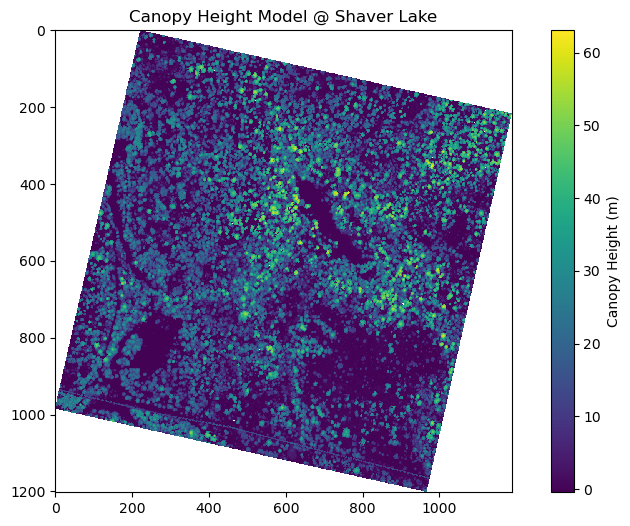

In [28]:
plt.figure(figsize=(10, 6))
plt.imshow(chm, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Canopy Height (m)")
plt.title("Canopy Height Model @ Shaver Lake")
plt.show()

In [21]:
# Normalize CHM 
chm_norm = (chm - np.nanmin(chm)) / (np.nanmax(chm) - np.nanmin(chm))

# Locate tree tops using local maxima filtering
tree_tops = peak_local_max(chm_norm, min_distance=3, threshold_abs=0.1, exclude_border=False)

# Convert pixel coordinates to geospatial coordinates and extract heights
tree_points = []
for row, col in tree_tops:
    x, y = transform * (int(col), int(row))  
    height = chm[row, col] 
    tree_points.append((height, y, x)) 

df = pd.DataFrame(tree_points, columns=["HT", "y", "x"])

# Let´s look at the df
df.head()

,HT,y,x
0,63.060001,1811859.0,-2027711.0
1,62.360001,1811791.0,-2027928.0
2,61.439999,1811907.0,-2028066.0
3,61.439999,1811864.0,-2027709.0
4,61.380001,1811788.0,-2027934.0


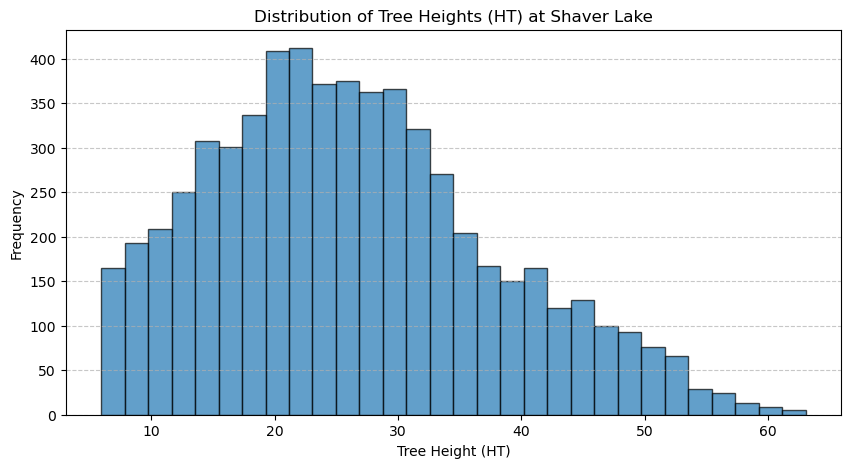

In [29]:
# Let's take a look at the distribution of tree heights
plt.figure(figsize=(10, 5))
plt.hist(df["HT"], bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Tree Height (HT)")
plt.ylabel("Frequency")
plt.title("Distribution of Tree Heights (HT) at Shaver Lake")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [23]:
# Convert to Lat/Lon system
if crs and crs.to_epsg() != 4326:
    transformer = Transformer.from_crs(crs.to_epsg(), "EPSG:4326", always_xy=True)
    df["x"], df["y"] = transformer.transform(df["x"].values, df["y"].values) 

# Save CSV
df.to_csv("./ttops_Dream-Team!.csv", index=False)
print(f"TreeTops saved with {len(df)} points")

TreeTops saved with 6002 points


## Analysis

The canopy height models and tree height distributions at Independence Lake and Shaver Lake reveal several similarities and differences. Both sites exhibit a right-skewed distribution of tree heights, with the majority of trees falling in the mid-height range and fewer tall trees, as seen in their respective histograms. Visually, the canopy height models show clustered vegetation with distinct patches of taller trees and some areas of low or no canopy. However, the Independence Lake graph has a higher maximum tree height (over 70 meters) compared to Shaver Lake (just above 60 meters), and its distribution is more centered around 30 meters, suggesting a generally taller and more uniform canopy. 
In contrast, Shaver Lake has a broader spread of lower tree heights, with a higher frequency of trees between 15 and 25 meters, indicating a potentially younger or more disturbed forest. Additionally, Independence Lake appears to have denser regions of tall canopy cover, while Shaver Lake shows more scattered patterns with greater presence of low-canopy or open areas across the CHM map. Overall, Independence Lake seems to host a more mature forest structure, while Shaver Lake reflects a younger or more variable landscape.